In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input,Conv2D , MaxPooling2D, UpSampling2D,Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_zip='/content/input/'
path='/content/working/'

In [ ]:
with zipfile.ZipFile(path_zip+'train.zip','r') as zip_ref:
    zip_ref.extractall(path)
with zipfile.ZipFile(path_zip+'test.zip','r') as zip_ref:
    zip_ref.extractall(path)
with zipfile.ZipFile(path_zip+'train_cleaned.zip','r') as zip_ref:
    zip_ref.extractall(path)
with zipfile.ZipFile(path_zip+'sampleSubmission.csv.zip','r') as zip_ref:
    zip_ref.extractall(path)


In [ ]:
train_img=sorted(os.listdir(path+'/train'))
train_cleaned_img=sorted(os.listdir(path+'/train_cleaned'))
test_img=sorted(os.listdir(path+'/test'))

In [ ]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype = "float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))

    return img

In [ ]:
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path+'train/')):
    train.append(process_image(path+ 'train/'+f))

for f in sorted(os.listdir(path+'train_cleaned/')):
    train_cleaned.append(process_image(path+ 'train_cleaned/'+f))

for f in sorted(os.listdir(path+'test/')):
    test.append(process_image(path+ 'test/'+f))

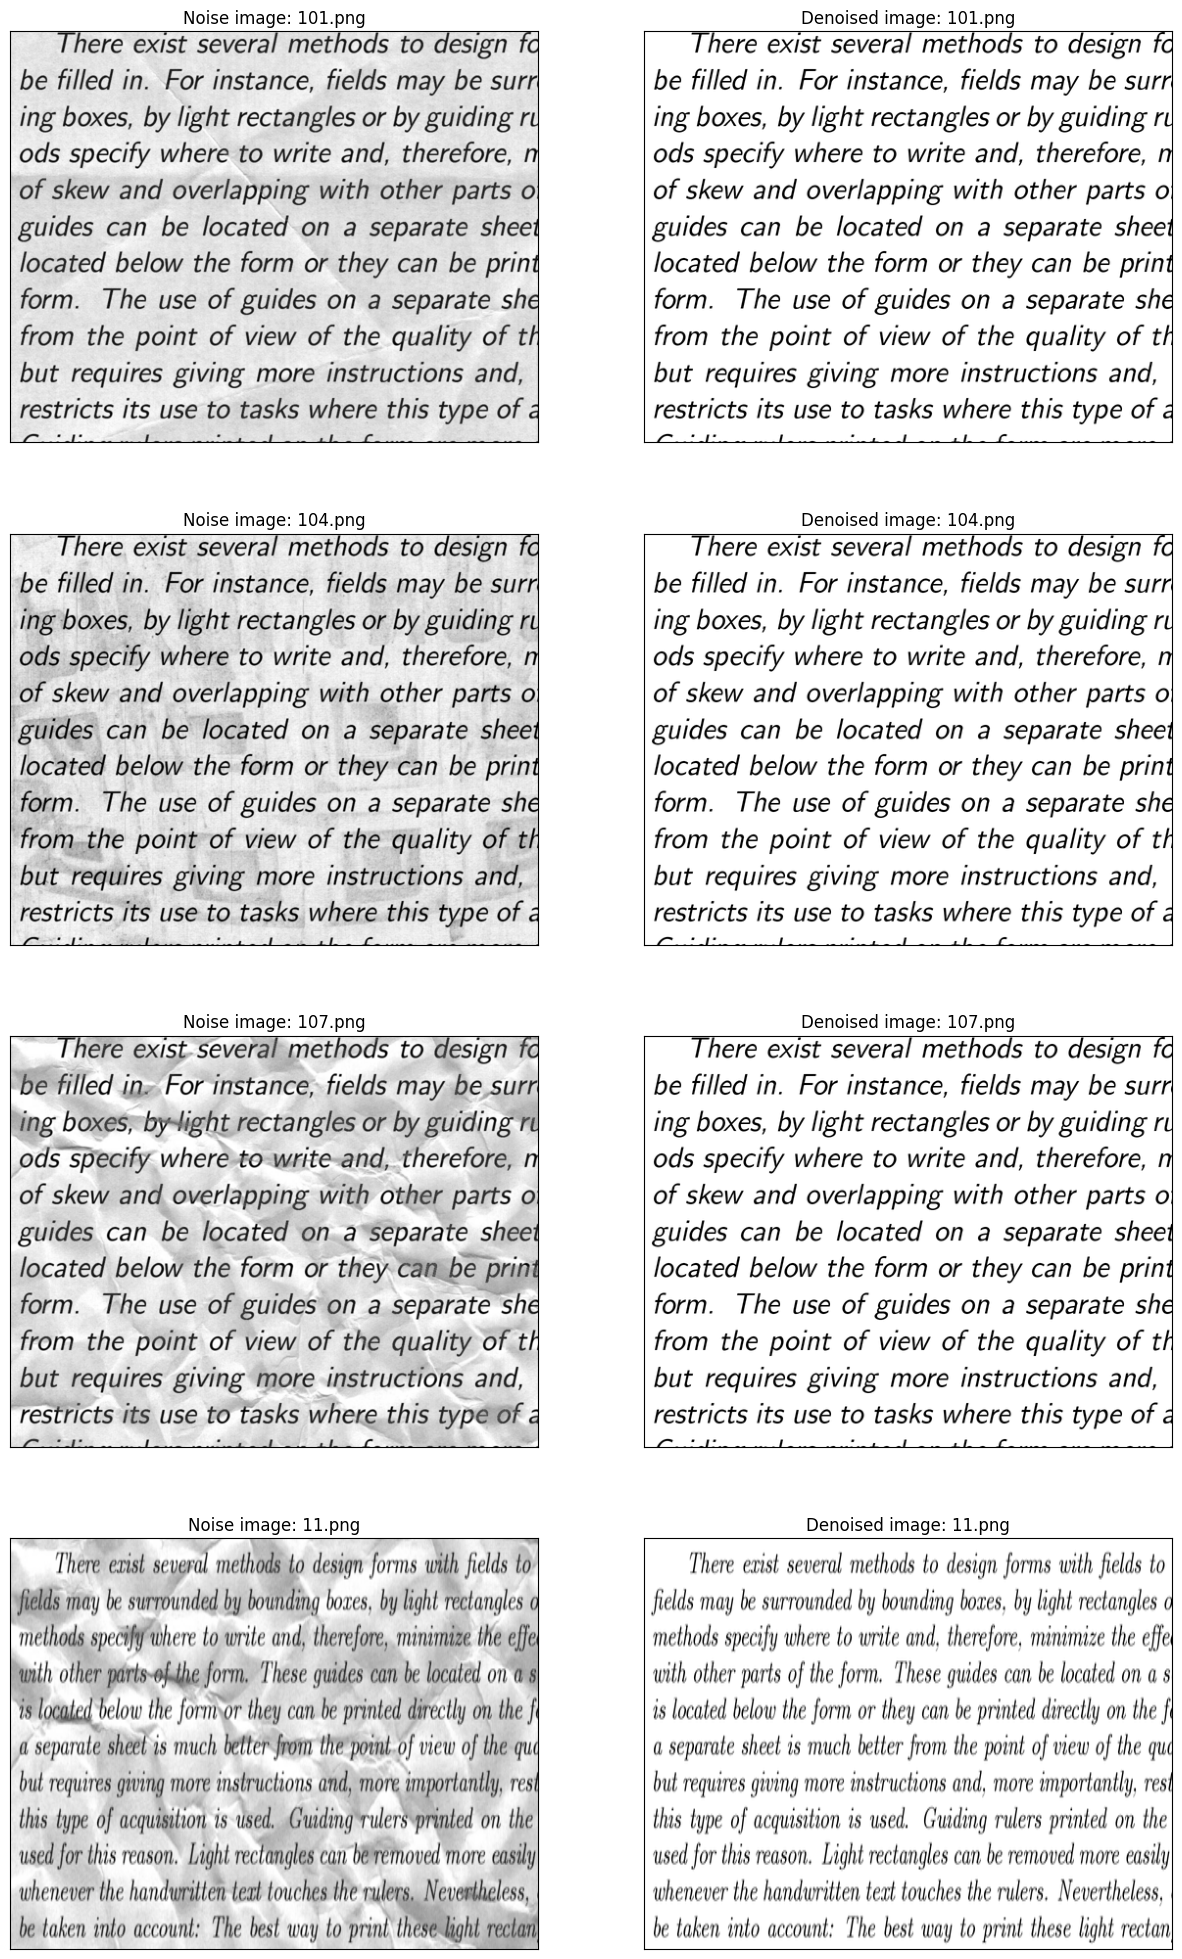

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0],cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))

    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0],cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()



**Architecture model will be used is Autoencoder**

In [ ]:
X_train =  np.asarray(train)
Y_train =  np.asarray(train_cleaned)
X_test = np.asarray(test)
X_train,X_val, Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.15)

In [ ]:
def model() :
    input_layer=Input (shape=(420,540,1))

    #encoding
    x = Conv2D(64,(3,3),activation='relu',padding='same')(input_layer)
    x = Conv2D(128,(3,3),activation='relu',padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2,2),padding='same')(x)

    x = Dropout(0.5)(x)

    #decoding
    x = Conv2D(128,(3,3),activation='relu',padding='same')(x)
    x = Conv2D(64,(3,3),activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)

    output_layer = Conv2D(1,(3,3),activation='sigmoid',padding='same')(x)
    model = Model(inputs=[input_layer],outputs=[output_layer])
    model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae'])

    return model

model = model()
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 420, 540, 64)      640       
                                                                 
 conv2d_6 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 batch_normalization_2 (Batc  (None, 420, 540, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 210, 270, 128)    0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 210, 270, 128)     0   

epochs is the amount of time to train the data, higher epochs will have lower loss. for each epoch the loss will decrease.

batch_size is the amount of sample processed at the same time.

In [ ]:
callback = EarlyStopping(monitor='loss',patience=30)
history = model.fit(X_train,Y_train,validation_data= (X_val,Y_val),epochs=300,batch_size=12, verbose=1, callbacks=[callback])

Epoch 1/300
11/11 [==============================] - 43s 2s/step - loss: 0.1243 - mae: 0.2609 - val_loss: 0.1816 - val_mae: 0.4142
Epoch 2/300
11/11 [==============================] - 11s 999ms/step - loss: 0.0496 - mae: 0.1627 - val_loss: 0.1285 - val_mae: 0.3464
Epoch 3/300
11/11 [==============================] - 11s 1s/step - loss: 0.0346 - mae: 0.1278 - val_loss: 0.0954 - val_mae: 0.2897
Epoch 4/300
11/11 [==============================] - 11s 1s/step - loss: 0.0271 - mae: 0.1090 - val_loss: 0.0761 - val_mae: 0.2412
Epoch 5/300
11/11 [==============================] - 11s 982ms/step - loss: 0.0224 - mae: 0.0976 - val_loss: 0.0679 - val_mae: 0.2027
Epoch 6/300
11/11 [==============================] - 11s 984ms/step - loss: 0.0183 - mae: 0.0913 - val_loss: 0.0662 - val_mae: 0.1868
Epoch 7/300
11/11 [==============================] - 11s 1s/step - loss: 0.0147 - mae: 0.0830 - val_loss: 0.0659 - val_mae: 0.1646
Epoch 8/300
11/11 [==============================] - 11s 991ms/step - loss

<function matplotlib.pyplot.show(close=None, block=None)>

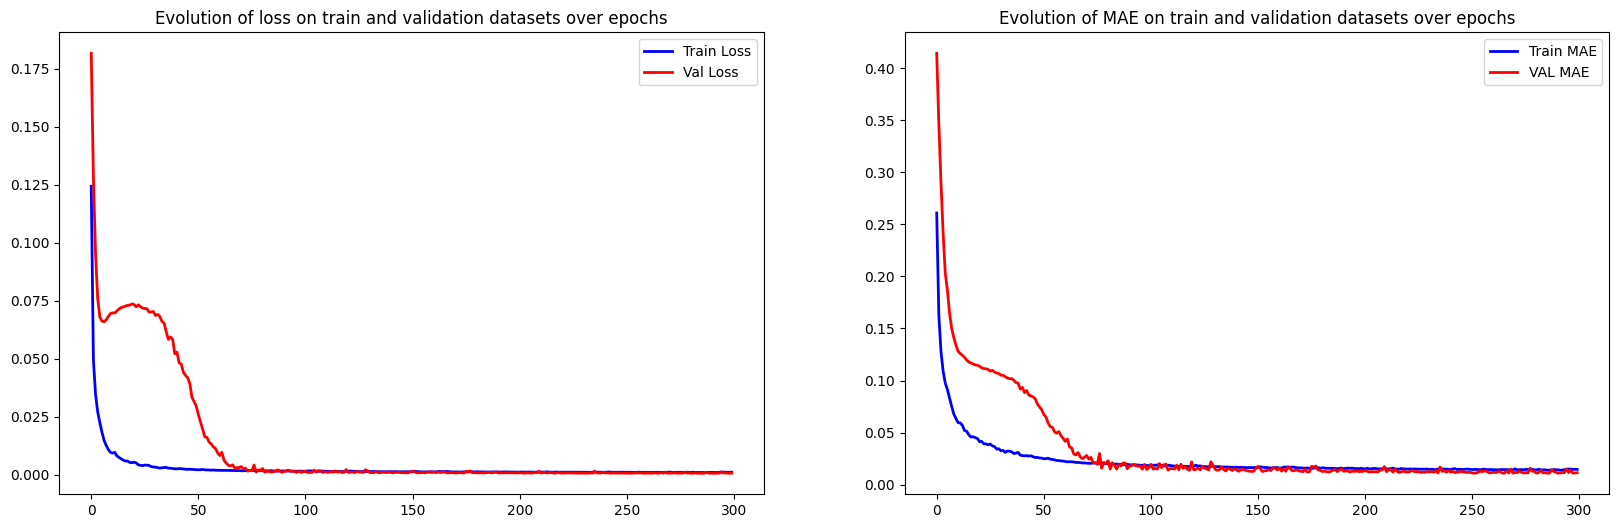

In [ ]:
#Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae =  history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)),epoch_loss,'b-',linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)),epoch_val_loss,'r-',linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train and validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)),epoch_mae,'b-',linewidth=2,label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)),epoch_val_mae,'r-',linewidth=2,label='VAL MAE')
plt.title('Evolution of MAE on train and validation datasets over epochs')
plt.legend(loc='best')

plt.show

train loss is the loss of trained data . validation loss is the loss of test data.At the end, the train loss and validation loss must be 0 and at the same epochs.

In [ ]:
#predict/clean test images
Y_test = model.predict(X_test, batch_size=16)

5/5 [==============================] - 11s 1s/step


NameError: ignored

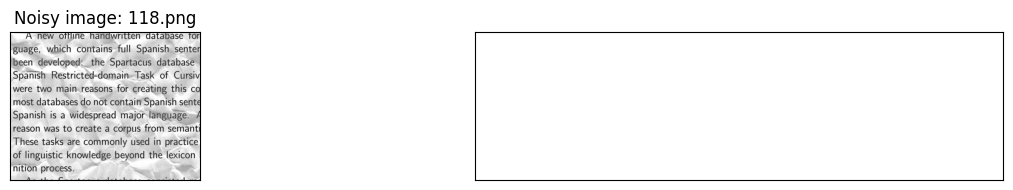

In [ ]:
plt.figure(figsize=(15,25))
for i in range (8,22,2):
    plt.subplot(11,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0],cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))

    plt.subplot(11,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0],cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))


In [ ]:
model_json =  model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk


In [ ]:
model.save('model_full.h5')

TEST

In [6]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
model = load_model('/content/drive/MyDrive/model_full.h5')

In [4]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype = "float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))

    return img

In [7]:
test1 = []
test1.append(process_image('/content/drive/MyDrive/working/test/10.png'))

X_test = np.asarray(test1)

In [8]:
predict = model.predict(X_test, batch_size=32)

1/1 [==============================] - 7s 7s/step


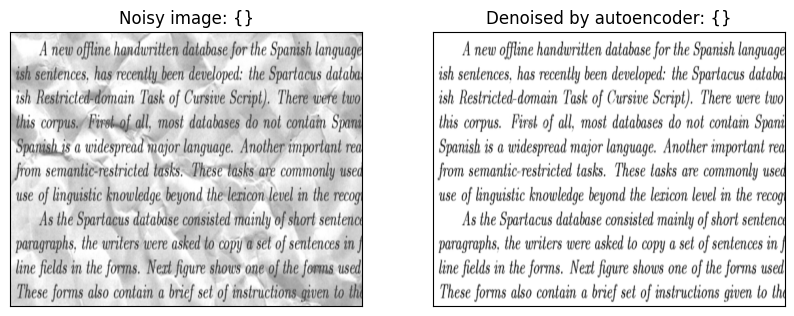

In [ ]:
plt.figure(figsize=(10,25))
for i in range (0,1):
    plt.subplot(1,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0],cmap='gray')
    plt.title('Noisy image:')

    plt.subplot(1,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(predict[i][:,:,0],cmap='gray')
    plt.title('Denoised by autoencoder:')
